## Calculate fold-change

In [1]:
import polars as pl

In [4]:
filt_dat = pl.read_csv("../00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv").filter(
    pl.col("Metadata_Categories") != "JUMP Control"
)

prot_keep = [i for i in filt_dat.columns if "Metadata" not in i]
cmpd_keep = filt_dat.select("Metadata_Compound").to_series().unique().to_list()


In [17]:
prot_dat = pl.read_csv("./inputs/proteomics_data/imputed_concentration.csv").filter(
    pl.col("Metadata_Compound") != "UNTREATED"
).filter(
    pl.col("Metadata_Compound").is_in(cmpd_keep)
)
feat_cols = [i for i in prot_dat.columns if "Metadata" not in i]

dat = prot_dat.unpivot(
    index=["Metadata_Compound", "Metadata_compound_concentration"],
    on=feat_cols,
    variable_name="Uniprot",
    value_name="Signal"
).filter(
    pl.col("Uniprot").is_in(prot_keep)
)

# Calculate mean concentration across replicates
dat = dat.group_by(["Metadata_Compound", "Metadata_compound_concentration", "Uniprot"]).agg([
    pl.mean("Signal")
])

# Add a column with DMSO conc for that protein
dat_dmso = dat.filter(pl.col("Metadata_Compound") == "DMSO").select(["Uniprot", "Signal"]).rename({"Signal": "DMSO_Uniprot_Signal"})
dat = dat.filter(pl.col("Metadata_Compound") != "DMSO").join(dat_dmso, on="Uniprot")

# calculate the log2FC
dat = dat.with_columns(
    (pl.col("Signal")/pl.col("DMSO_Uniprot_Signal")).alias("ratio"),
).with_columns(
    pl.col("ratio").log(base=2).alias("log2fc")
)

In [18]:
# calculate the max fold-change per compound
max_fc_long = (
    dat.with_columns([
        pl.col("log2fc").abs().alias("abs_log2fc")
    ])
    .sort("abs_log2fc", descending=True)
    .group_by(["Metadata_Compound", "Uniprot"])
    .agg([
        pl.col("log2fc").first().alias("max_fc")
    ])
)

max_fc = max_fc_long.pivot(
    index="Metadata_Compound",
    on="Uniprot",
    values="max_fc"
)

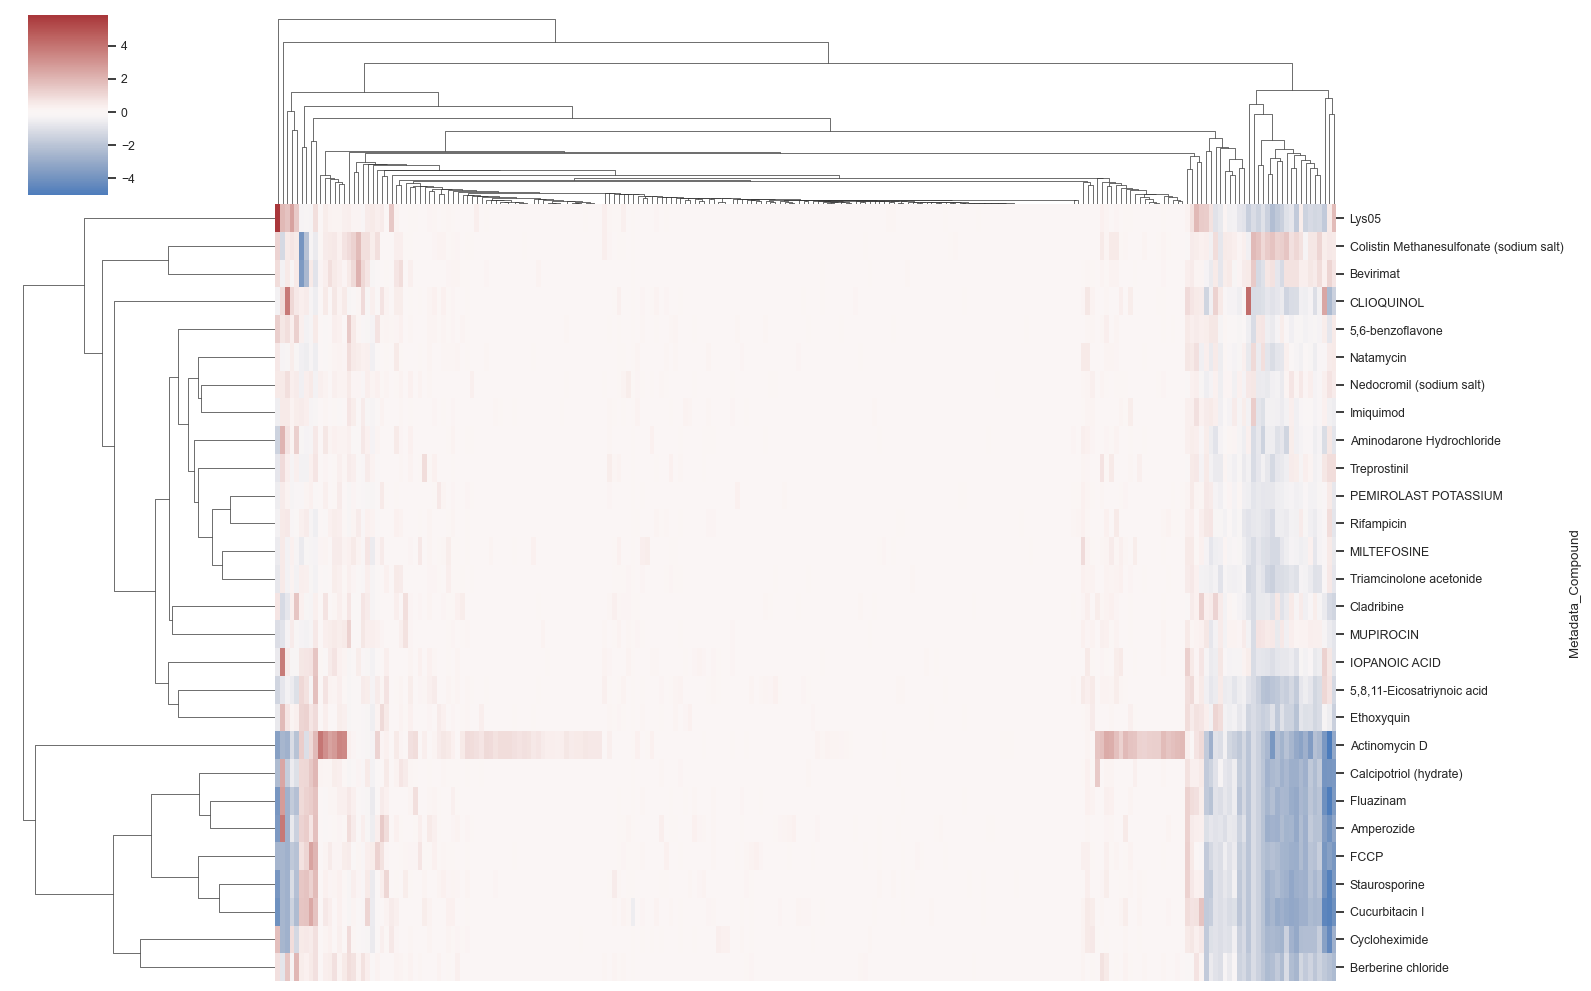

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = max_fc.to_pandas()
df = df.set_index("Metadata_Compound")

sns.set(font_scale=0.8)
g = sns.clustermap(
    df,
    cmap="vlag",
    center=0, 
    figsize=(16, 10),
    xticklabels=False,
    yticklabels=True,
    metric="euclidean",
    method="average",
)

plt.show()

In [22]:
print(bmd_prot)

['Decorin', 'ANGPT1', 'CCL5', 'IL-8', 'TNF beta', 'MIF', 'MMP-1', 'FLRG (FSTL3)', 'TWEAK R (CD266)', 'CCL15', 'C5/C5a', 'ADAM9', 'GAS6', 'Galectin-1', 'TGF-beta 1 (LAP)', 'CCL24', 'CCL20', 'IGFBP-3', 'VEGF-A (165)', 'SAA', 'IL-33 R (ST2)', 'BMP6', 'IL-11', 'NGF beta', 'CCL27', 'TGF-beta 1 (total)', 'CXCL1', 'CXCL16', 'IGFBP-6', 'CCL2', 'CXCL9', 'MMP-3', 'EGFR', 'Osteoactivin (GPNMB)', 'IGF-1', 'Oncostatin M (OSM)', 'ANGPTL4', 'CCL7', 'EMMPRIN', 'ECM1', 'Cytochrome C', 'TIMP2', 'TIMP1', 'PCOLCE', 'CXCL11', 'Mesothelin', 'CXCL10', 'TGFBI (beta ig-h3)', 'DPP4 (CD26)', 'CHI3L1', 'GDF-15 (MIC-1)', 'M-CSF', 'TNF R1', 'NGAL (lipocalin-2)', 'Fibulin-3', 'MMP-7', 'DR6', 'VEGF-C', 'M-CSF R (CD115)', 'CCL28', 'CXCL3']


/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_4091/4259865779.py:6: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


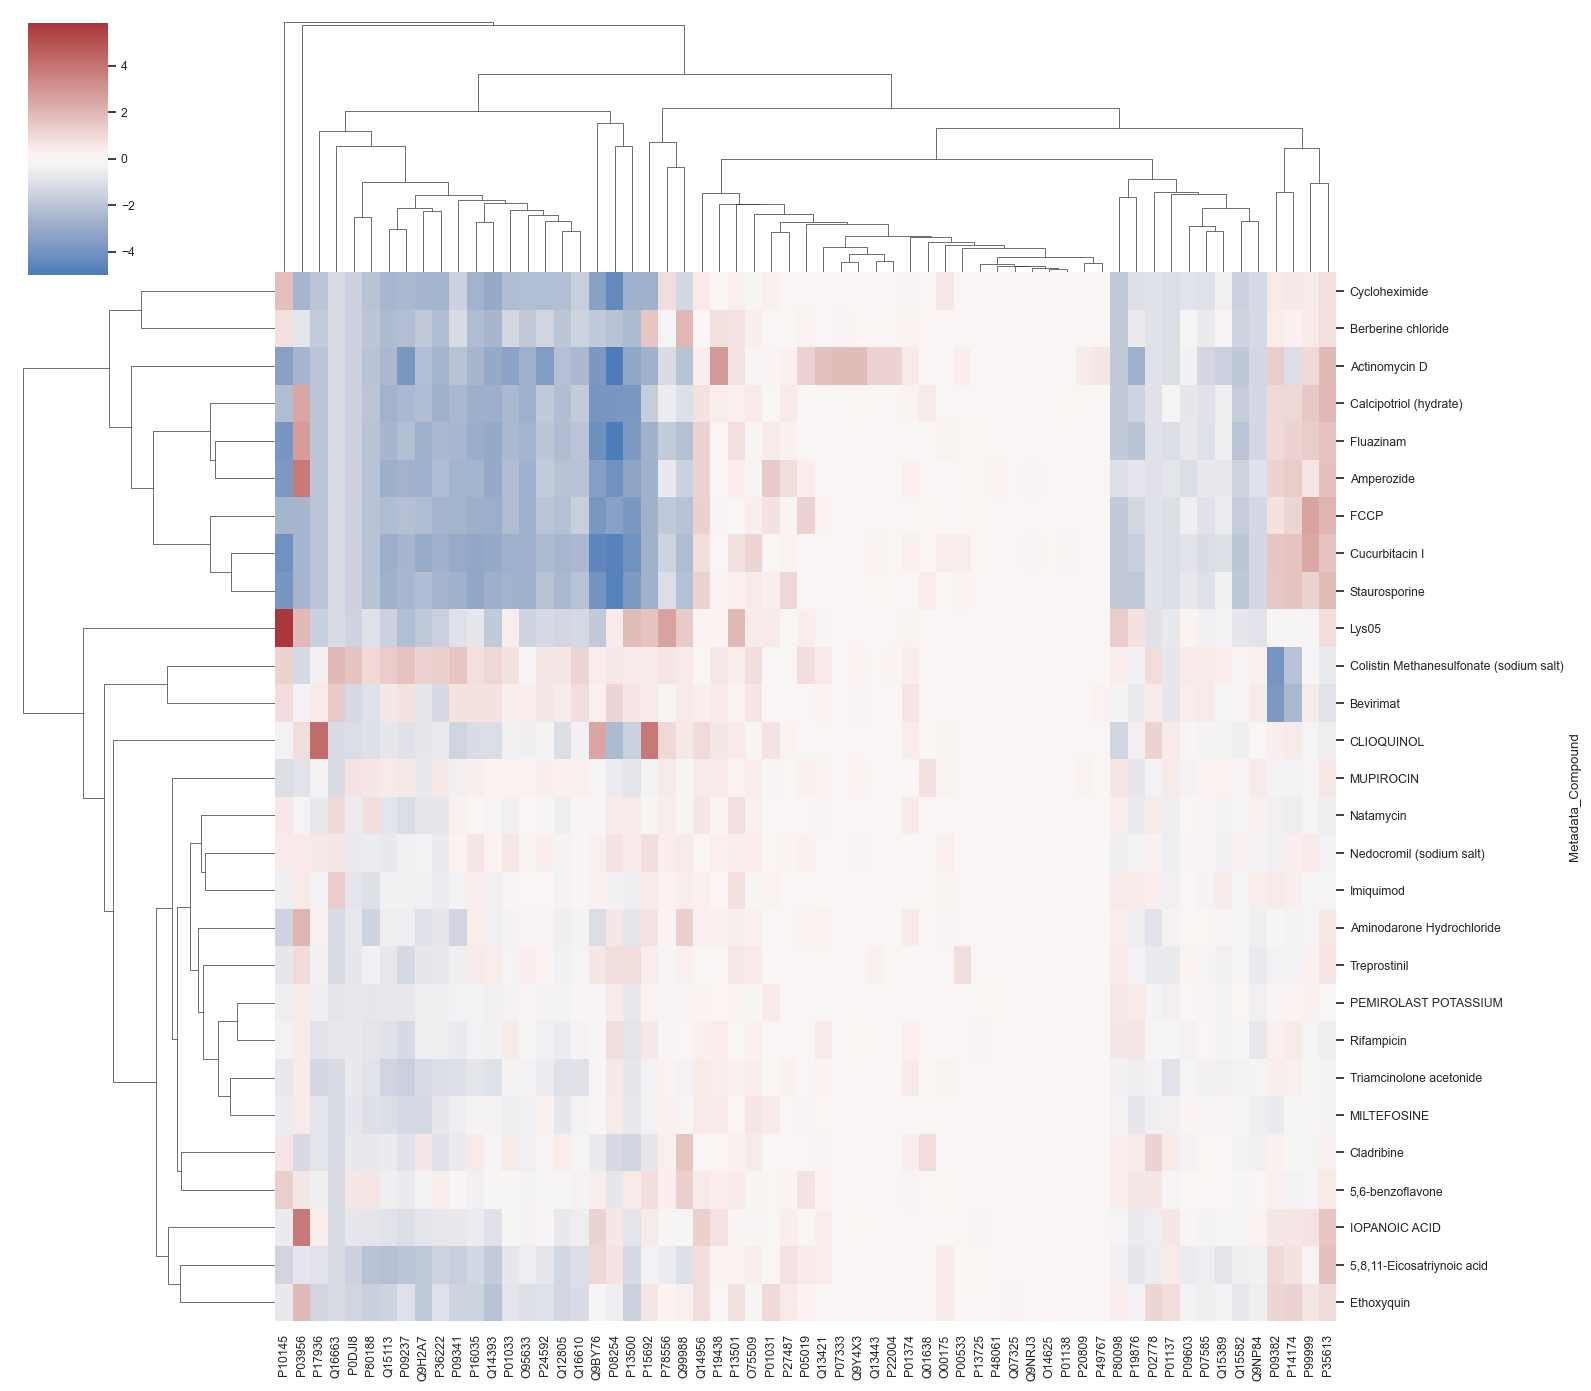

In [24]:
# Filter out proteins that do not respond to any compound
bmd_res = pl.read_csv("../01.dose_response/outputs/bmd_pass_with_protein_name.csv")
prot_count = (
    bmd_res
    .group_by("gene.id")
    .count()
    .sort("count", descending=True)
).filter(pl.col("count") > 2)

bmd_prot = prot_count.select("gene.id").to_series().unique().to_list()

df = max_fc_long.filter(pl.col("Uniprot").is_in(bmd_prot)).pivot(
    index="Metadata_Compound",
    on="Uniprot",
    values="max_fc"
).to_pandas()
df = df.set_index("Metadata_Compound")

sns.set(font_scale=0.8)
g = sns.clustermap(
    df,
    cmap="vlag",
    center=0, 
    figsize=(16, 14),
    xticklabels=True,
    yticklabels=True,
    metric="euclidean",
    method="average",
)

plt.show()

/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_4091/2813847360.py:13: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


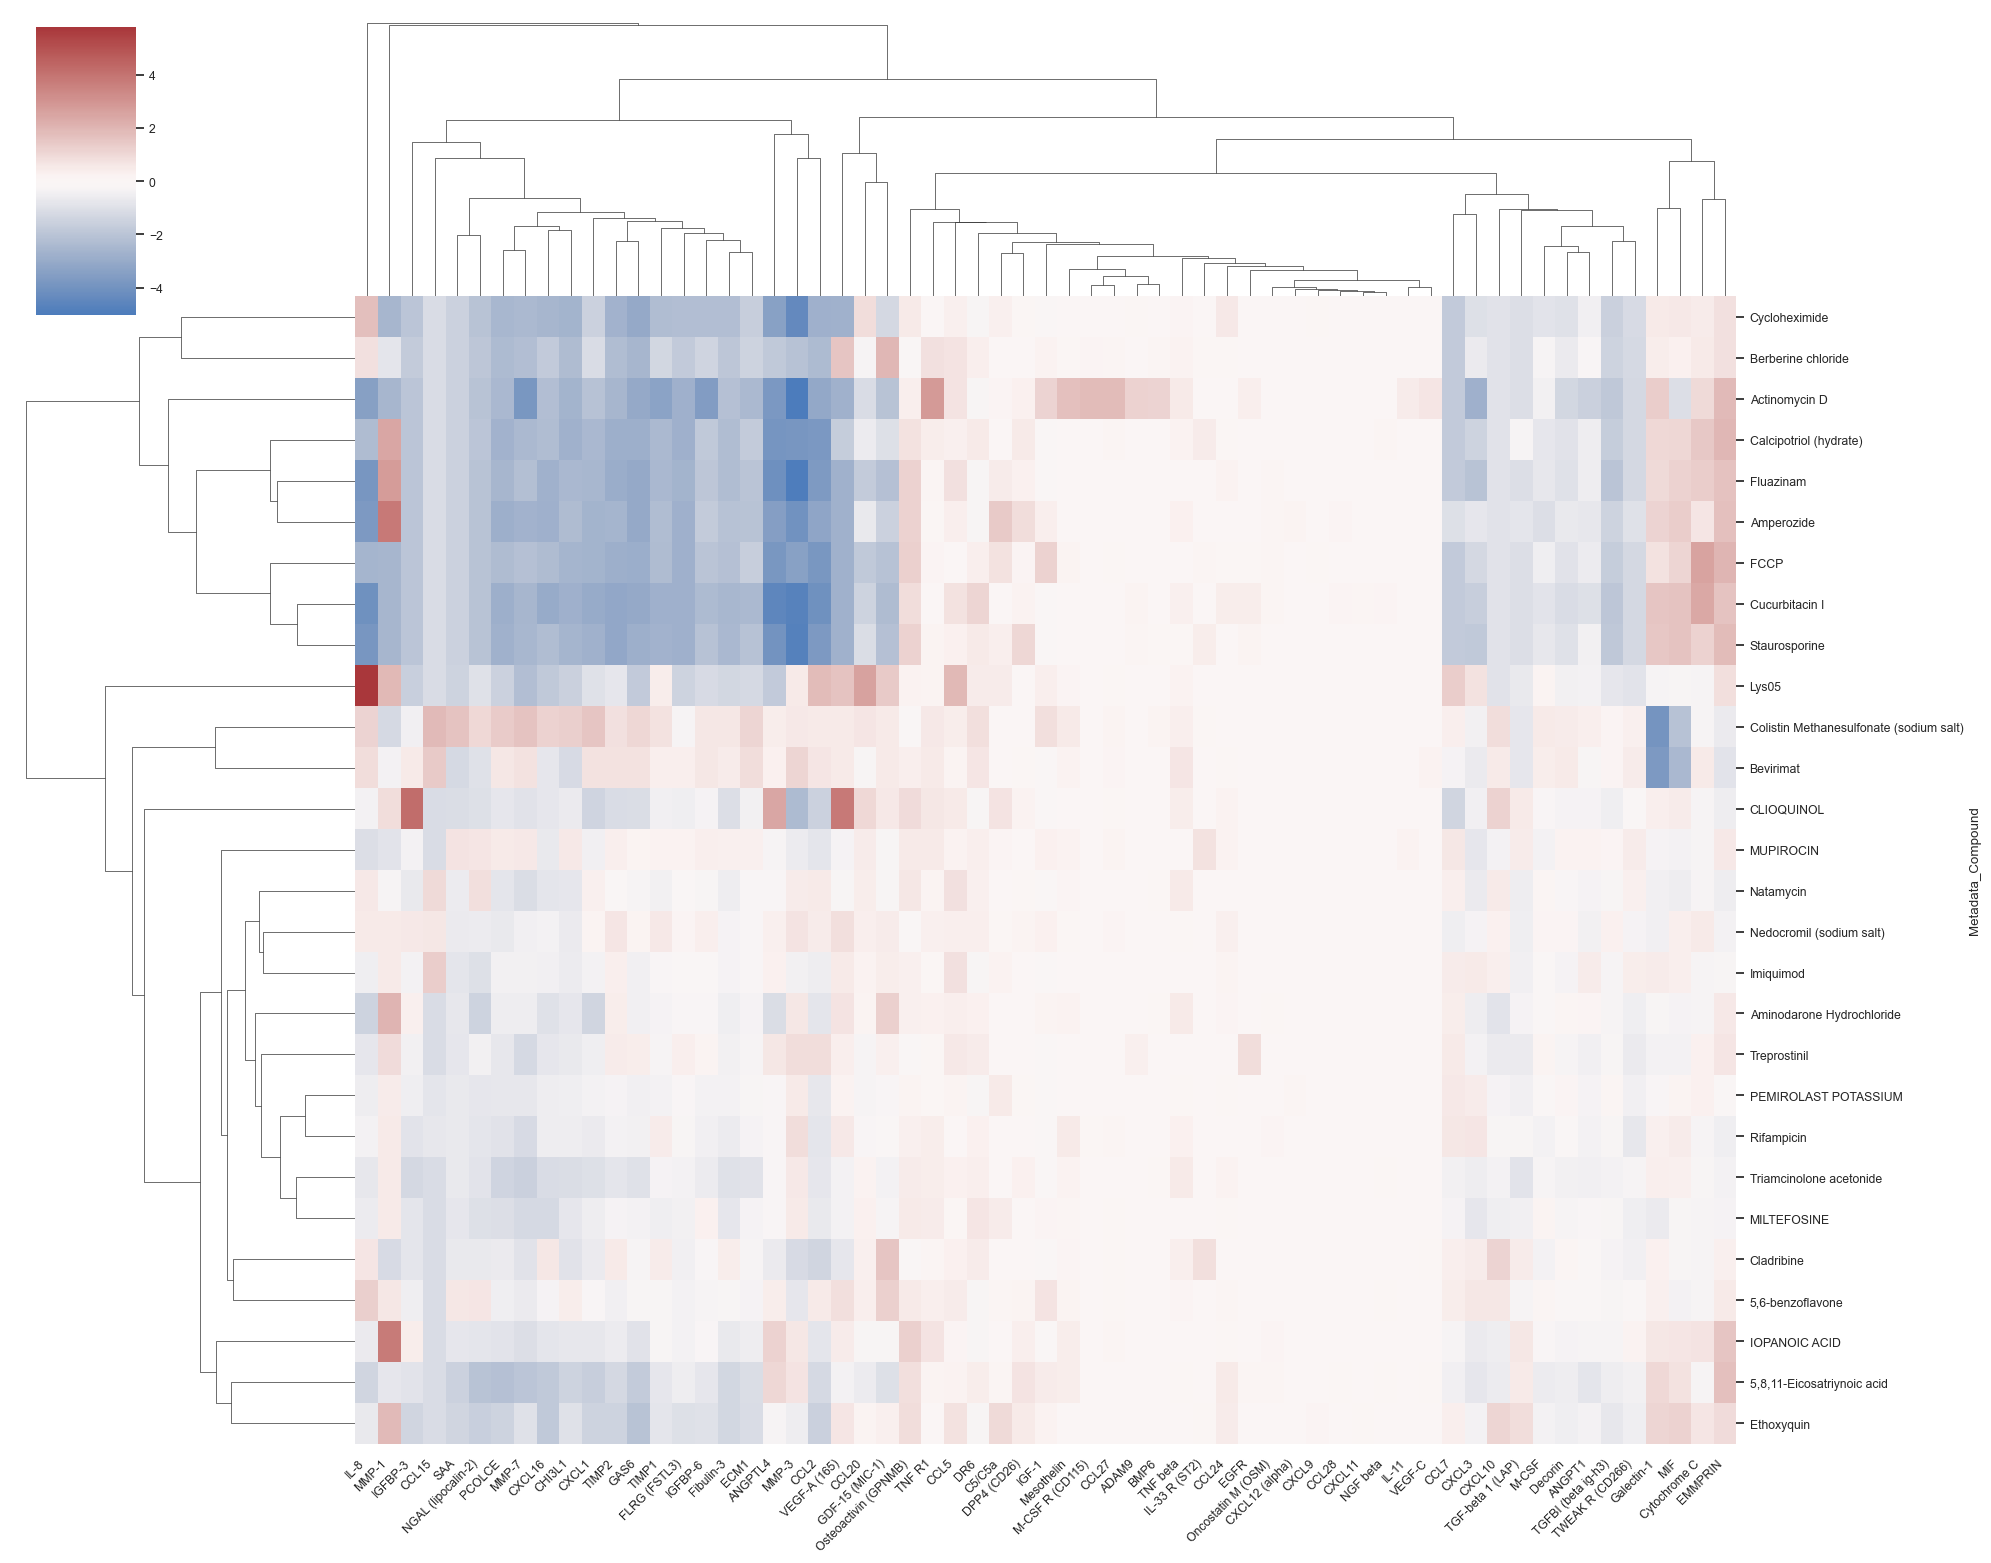

In [ ]:

bmd_res = pl.read_csv("../01.dose_response/outputs/bmd_pass_with_protein_name.csv")

prot_count = (
    bmd_res
    .group_by("gene.id")
    .count()
    .sort("count", descending=True)
).filter(pl.col("count") > 2)

bmd_prot = prot_count.select("gene.id").to_series().unique().to_list()

gene_to_protein = (
    bmd_res
    .filter(pl.col("gene.id").is_in(bmd_prot))
    .unique(subset=["gene.id"])  
    .select(["gene.id", "protein"])
    .to_pandas()
    .set_index("gene.id")["protein"]
    .to_dict()
)

df = max_fc_long.filter(pl.col("Uniprot").is_in(bmd_prot)).pivot(
    index="Metadata_Compound",
    on="Uniprot",
    values="max_fc"
).to_pandas()

df = df.set_index("Metadata_Compound")
df = df.rename(columns=gene_to_protein)

sns.set(font_scale=0.8)
g = sns.clustermap(
    df,
    cmap="vlag",
    center=0, 
    figsize=(20, 16),
    xticklabels=True,
    yticklabels=True,
    metric="euclidean",
    method="average",
)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")

plt.show()
